# 📦 Libraries Importing
### We import essential Python libraries required for data manipulation, natural language processing, visualization, and model training.

### They include `pandas`, `nltk`, `matplotlib`, `scikit-learn`, and others used throughout the workflow.

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to process words
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# SK-Learn Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score

# Library to translate
from textblob import TextBlob

# Library to display WordCloud
from wordcloud import WordCloud

# Library to load data from KaggleHub website
import kagglehub
import os

# Define a global Random State
RANDOM_STATE = 42

# 📂 Data Loading
### We load the dataset from a CSV file containing user statements and their corresponding mental health labels. This step initializes the core DataFrame used throughout the pipeline.

In [ ]:
# Download the dataset using KaggleHub
dataset_dir = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

# Recursively walk through the downloaded directory and print all file paths
for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the main CSV into a DataFrame
df = pd.read_csv(fr'{dataset_dir}/Combined Data.csv', index_col=0)

/Users/leonh/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv


# 🔍 Data Inspection
### We perform an initial inspection of the dataset to understand its structure, class distribution, and potential data quality issues. This includes checking for missing values, unique label counts, and example statements.

In [ ]:
# Dataset Info
print("Dataset Info:")
print(df.count())
print("")

# Count NA in the dataset
print("Missing Values:")
print(df.isnull().sum())
print("")

# Display the first few rows of the dataframe
print("Dataset Preview:")
print(df.head())

Dataset Info:
statement    52681
status       53043
dtype: int64

Missing Values:
statement    362
status         0
dtype: int64

Dataset Preview:
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


### We also use a pie chart to inspect the distribution of data

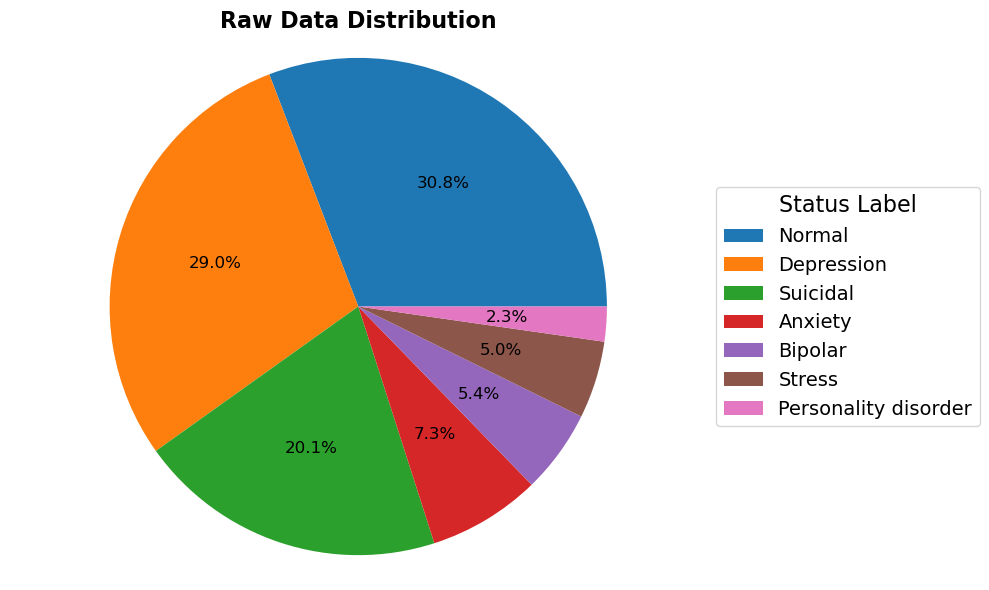

In [ ]:
# Prepare the data
status_counts = df['status'].value_counts()
labels = status_counts.index
sizes = status_counts.values

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))

# Style the percentage text
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    autopct='%1.1f%%',
    textprops={'fontsize': 12}
)

# Title
ax.set_title('Raw Data Distribution', fontsize=16, fontweight='bold', pad=0)

# Adjust legend
ax.legend(
    wedges, labels,
    title="Status Label",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=14,
    title_fontsize=16
)

# Equal aspect ratio ensures the pie is drawn as a circle
ax.axis('equal')

# Show the pie
plt.tight_layout()
plt.show()

# 🧹 Data Cleaning

### Because the number of rows with missing values occupies less than 1% of the dataset, we can safely remove them. In fact, we conclude that removing all N/A values actually improves the overall accuracy by 2%.

In [140]:
# Remove all N/A rows
df = df.dropna(subset=['statement']).reset_index(drop=True)

### We also reduce noise from the dataset by filtering out: punctuation, numbers, and non common English words using NLTK.

In [ ]:
# Download necessary dictionaries
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# A function to Filter out punctuation, numbers, and non-common English words
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

# Apply the filter
df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /Users/leonh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/leonh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/leonh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

# Define a function to filter stopwords from a text string
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the filter
df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

# 🧬 Data Augmentation

### Translation introduces natural variations in phrasing while preserving semantic meaning. To enrich the lexical and emotional diversity of the dataset, we applied data augmentation using back-translation through five different languages:

### Languages selected for back-translation:  
- French (`fr`)  
- Italian (`it`)  
- Spanish (`es`)  
- German (`de`)  
- Portuguese (`pt`)

### Each original English sentence was translated into one of these languages and then back into English, then accumulated into the original dataset. This technique helps improve model generalization, particularly in detecting nuanced mental health expressions.

In [125]:
# The back translator
def augment_text(text, target_language='fr'):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to=target_language).translate(to='en')
        return str(translated)
    except Exception:
        return text

# The base data before any augmentation
base_df = df[['statement', 'status', 'cleaned_statement']].copy()

# Create a list to collect all DataFrames
augmented_list = [base_df]

for language in ['fr', 'it', 'es', 'de', 'pt']:
    
    # Copy from the base to avoid stacking translation
    augmented_df = base_df[['statement', 'status']].copy()
    
    # Augments and stores the results in a new df 'augmented_statement'
    augmented_df['statement'] = augmented_df['statement'].apply(lambda x: augment_text(x, target_language=language))

    # Dropna to improve efficiency
    augmented_df = augmented_df.dropna(subset=['statement']).reset_index(drop=True)
    
    # Apply the same pre-process and remove stopwords on the new augmented data
    augmented_df['cleaned_statement'] = augmented_df['statement'].apply(lambda x: remove_stopwords(preprocess_text(x)))
    
    # Append the new augmented data to a augmentation list
    augmented_list.append(augmented_df)

# Merge augmented data with the original (accumulate the base)
df = pd.concat(augmented_list, ignore_index=True)

# Splitting the data
X = df['cleaned_statement']
y = df['status']

# 🖼️ Data Visualize

### We use the Pie chart to represent the distribution of the cleaned dataset, which barely changes.

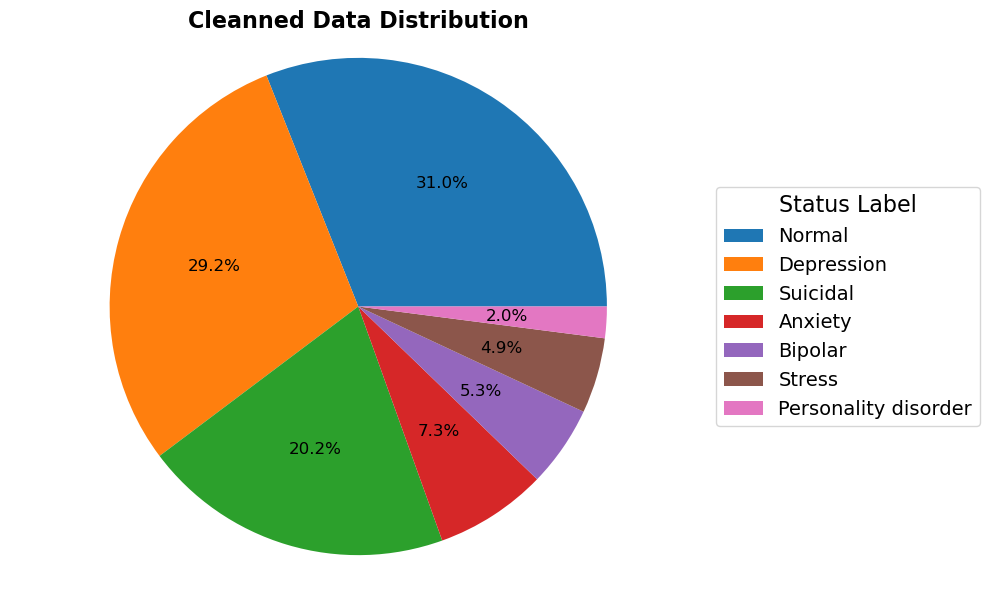

In [ ]:
# Prepare the data
status_counts = df['status'].value_counts()
labels = status_counts.index
sizes = status_counts.values

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    autopct='%1.1f%%',
    textprops={'fontsize': 12}
)

# Title
ax.set_title('Cleanned Data Distribution', fontsize=16, fontweight='bold', pad=0)

# Adjust legend
ax.legend(
    wedges, labels,
    title="Status Label",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=14,
    title_fontsize=16
)

# Equal aspect ratio ensures the pie is drawn as a circle
ax.axis('equal')

# Show the pie
plt.tight_layout()
plt.show()

### Then, we visualize important words in the dataset via Word Cloud. The bigger the text, the more important and valuable it is.

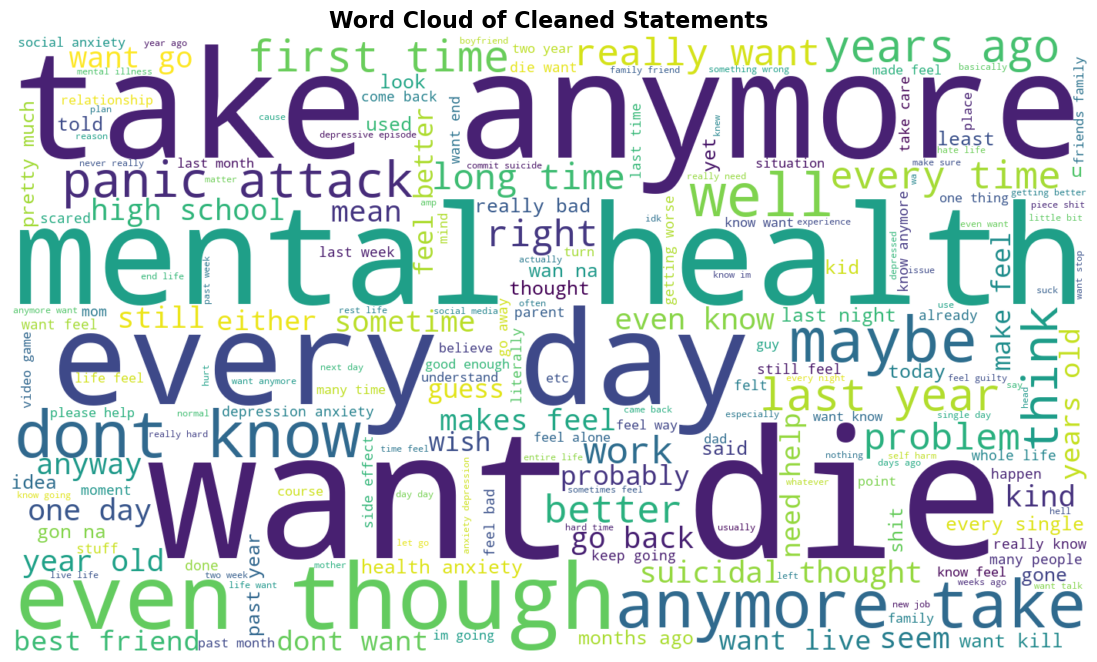

In [127]:
# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=1400, height=800, background_color='white', random_state=RANDOM_STATE).generate(all_text)
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements', fontsize=16, fontweight='bold')
plt.show()

# 🤖 Model Training
### We use Logistic Regression as our baseline classifier due to its simplicity and interpretability.

In [87]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Text data is transformed into numerical feature vectors using TF-IDF (Term Frequency–Inverse Document Frequency), with the limit of max of features of 10,000 to balance performance and expressiveness.

In [88]:
# Vectorization: Convert text values to numeric values for calculation
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Hyperparameters are optimized using GridSearchCV with 5-fold cross-validation and parallel computation (`n_jobs=-1`).

In [ ]:
# List of hyperparameter to use for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Hyperparameter Tuning
model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Get the best model from Hyperparameter tuning
best_model = grid_search.best_estimator_

### Finally, use the model to predict using test set.

In [90]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

# 📊 Evaluation

### The model is evaluated on a held-out test set using accuracy, precision, recall, and F1-score.

In [137]:
# Evaluation results
print("Best Parameters: ", grid_search.best_params_)
print()

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print()

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:  {'C': 100}

Accuracy Score:  0.9415198203043437

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.99      0.99      0.99      4509
             Bipolar       1.00      1.00      1.00      3331
          Depression       0.91      0.91      0.91     18321
              Normal       0.98      0.99      0.99     19890
Personality disorder       1.00      1.00      1.00      1256
              Stress       1.00      0.99      1.00      3078
            Suicidal       0.87      0.86      0.87     12833

            accuracy                           0.94     63218
           macro avg       0.96      0.96      0.96     63218
        weighted avg       0.94      0.94      0.94     63218



### We use a confusion matrix to visualize the precision and recall of the classification among 7 labels.

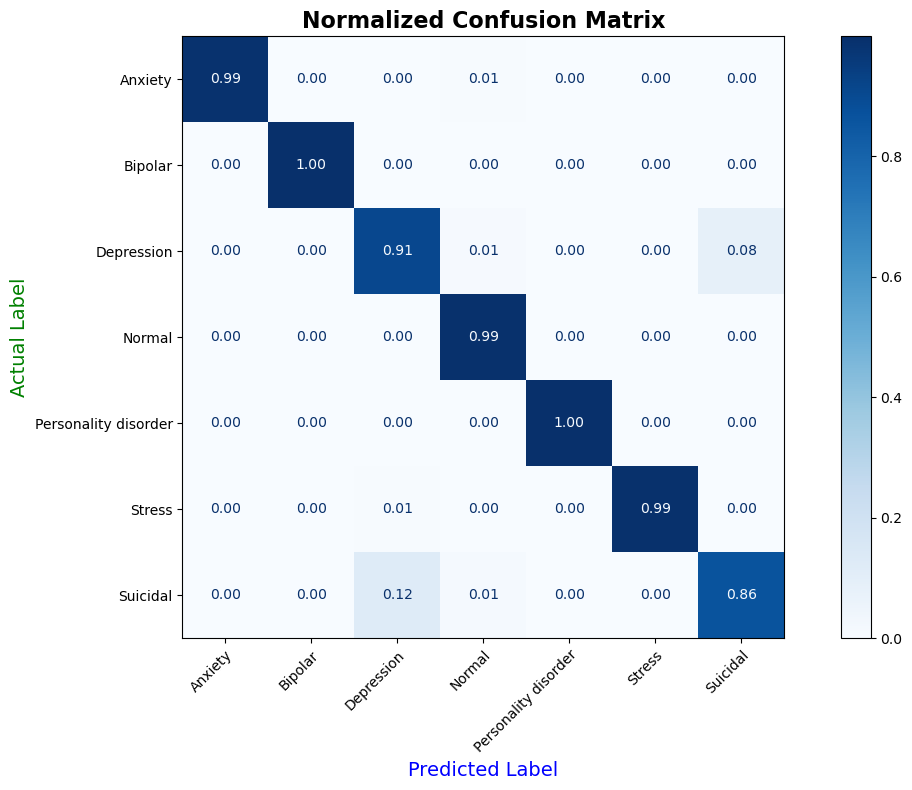

In [ ]:
# Compute normalized confusion matrix
labels = sorted(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f", colorbar=True)

# Label formatting
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Titles and axis labels
ax.set_title("Normalized Confusion Matrix", fontsize=16, fontweight='bold')
ax.set_xlabel("Predicted Label", fontsize=14, color='blue')
ax.set_ylabel("Actual Label", fontsize=14, color='green')

# Show the matrix
plt.tight_layout()
plt.show()

### We also apply bootstrapping to estimate confidence intervals for accuracy and macro F1, and analyze cross-validation consistency.

In [133]:
# Define number of bootstrap samples
n_bootstraps = 1000
rng = np.random.RandomState(RANDOM_STATE)

# Store bootstrap results
acc_scores = []
f1_scores = []

# Create bootstrapped datasets
for _ in range(n_bootstraps):
    # Resample with replacement
    indices = rng.randint(0, len(y_test), len(y_test))
    y_true_sample = np.array(y_test)[indices]
    y_pred_sample = np.array(y_pred)[indices]

    # Accumulate acc_scores and f1_scores
    acc_scores.append(accuracy_score(y_true_sample, y_pred_sample))
    f1_scores.append(f1_score(y_true_sample, y_pred_sample, average='macro'))

# Convert to NumPy arrays
acc_scores = np.array(acc_scores)
f1_scores = np.array(f1_scores)

# Compute 95% confidence intervals
acc_ci = np.percentile(acc_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])
print(f"Accuracy CI (95%) from: {acc_ci[0]:.4f} to {acc_ci[1]:.4f}")
print(f"Macro F1 CI (95%) from: {f1_ci[0]:.4f} to {f1_ci[1]:.4f}")

# Use Cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"CV mean accuracy: {np.mean(cv_scores):.4f}")
print(f"CV std deviation: {np.std(cv_scores):.4f}")

Accuracy CI (95%) from: 0.9397 to 0.9432
Macro F1 CI (95%) from: 0.9629 to 0.9651
CV mean accuracy: 0.8519
CV std deviation: 0.0006


### Visualize the distribution of accuracy and macro F1.

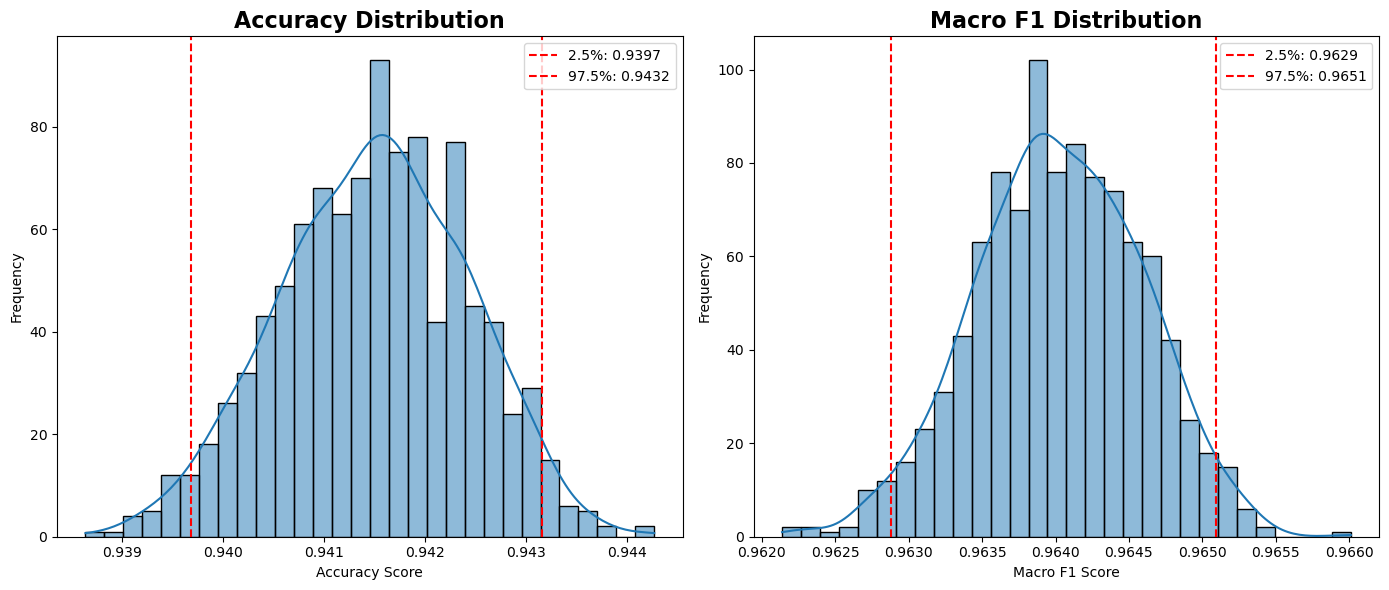

In [ ]:
# Create the figure
plt.figure(figsize=(14, 6))

# Accuracy Distribution
plt.subplot(1, 2, 1)
sns.histplot(acc_scores, kde=True, bins=30)
plt.axvline(acc_ci[0], color='red', linestyle='--', label=f'2.5%: {acc_ci[0]:.4f}')
plt.axvline(acc_ci[1], color='red', linestyle='--', label=f'97.5%: {acc_ci[1]:.4f}')
plt.title('Accuracy Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.legend()

# Macro F1 Distribution
plt.subplot(1, 2, 2)
sns.histplot(f1_scores, kde=True, bins=30)
plt.axvline(f1_ci[0], color='red', linestyle='--', label=f'2.5%: {f1_ci[0]:.4f}')
plt.axvline(f1_ci[1], color='red', linestyle='--', label=f'97.5%: {f1_ci[1]:.4f}')
plt.title('Macro F1 Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Macro F1 Score')
plt.ylabel('Frequency')
plt.legend()

# Show both graphs
plt.tight_layout()
plt.show()